In [33]:
from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15, 'figure.figsize':(15, 10)})
import numpy as np
from gtsimulation.Algos import BunemanBorisSimulator
from gtsimulation.Global import Regions, Units
from gtsimulation.MagneticFields.Heliosphere import Parker
from gtsimulation.Particle import Generators, Flux


In [20]:
date = datetime(2008, 1, 1)
region = Regions.Heliosphere
region.value.set_params(CalcAdditionalEnergy=True)
bfield = Parker()

medium = None
use_decay = False
nuclear_interaction = None

flux = Flux(
    Spectrum=Generators.Spectrums.UserInput(energy=np.logspace(2.5, 4.5, 10, endpoint=True)*Units.MeV),
    Distribution=Generators.Distributions.SphereSurf(Center=np.array([1, 0, 0])*Units.AU, Radius=0),
    Names="proton",
    Nevents=10,
)

save = [100, {'Energy': True, 'Clock': True}]
steps = 1000000
dt = 0.1

forward_tracking = 1
nfiles = 10
output = None

break_conditions = {"Rmax": 80*Units.AU}
verbose = True

In [24]:
simulator_BB = BunemanBorisSimulator(
    Bfield=bfield,
    Region=region,
    Medium=medium,
    Particles=flux,
    InteractNUC=nuclear_interaction,
    UseDecay=use_decay,
    Date=date,
    Step=dt,
    Num=steps,
    Nfiles=nfiles,
    BreakCondition=break_conditions,
    Save=save,
    Output=output,
    ForwardTrck=forward_tracking,
    Verbose=verbose
)

tracks = simulator_BB()

Creating simulator object...
	Date: 2008-01-01 00:00:00

	Time step: 0.1
	Number of steps: 1000000

	Radiation Losses: False
	Synchrotron Emission: False

	Region: Heliosphere
		Additional Energy Losses: True

	Number of files: 10
	Output file name: None_num.npy
	Save every 100 step of:
		Coordinates: True
		Velocities: True
		Efield: False
		Bfield: False
		Angles: False
		Path: False
		Density: False
		Clock: True
		Energy: True

	Electric field: None
	Magnetic field: Parker
        Regular: True
        Magnitude: 2.09
        HCS: True
        CIR: False
        Polarity: -1
        Noise: False
        

	Medium: None

	Decay: False
	Nuclear Interactions: None

	Flux: 
        Number of particles: 10
        Particles: ['proton']
        V: Isotropic
        Spectrum: User Input
        Energy size: 10
        Distribution: Sphere Surface
        Center: [1.49597871e+11 0.00000000e+00 0.00000000e+00]
        Radius: 0

	Break Conditions: 
		Xmin: 0.0
		Ymin: 0.0
		Zmin: 0.0
		Rmin

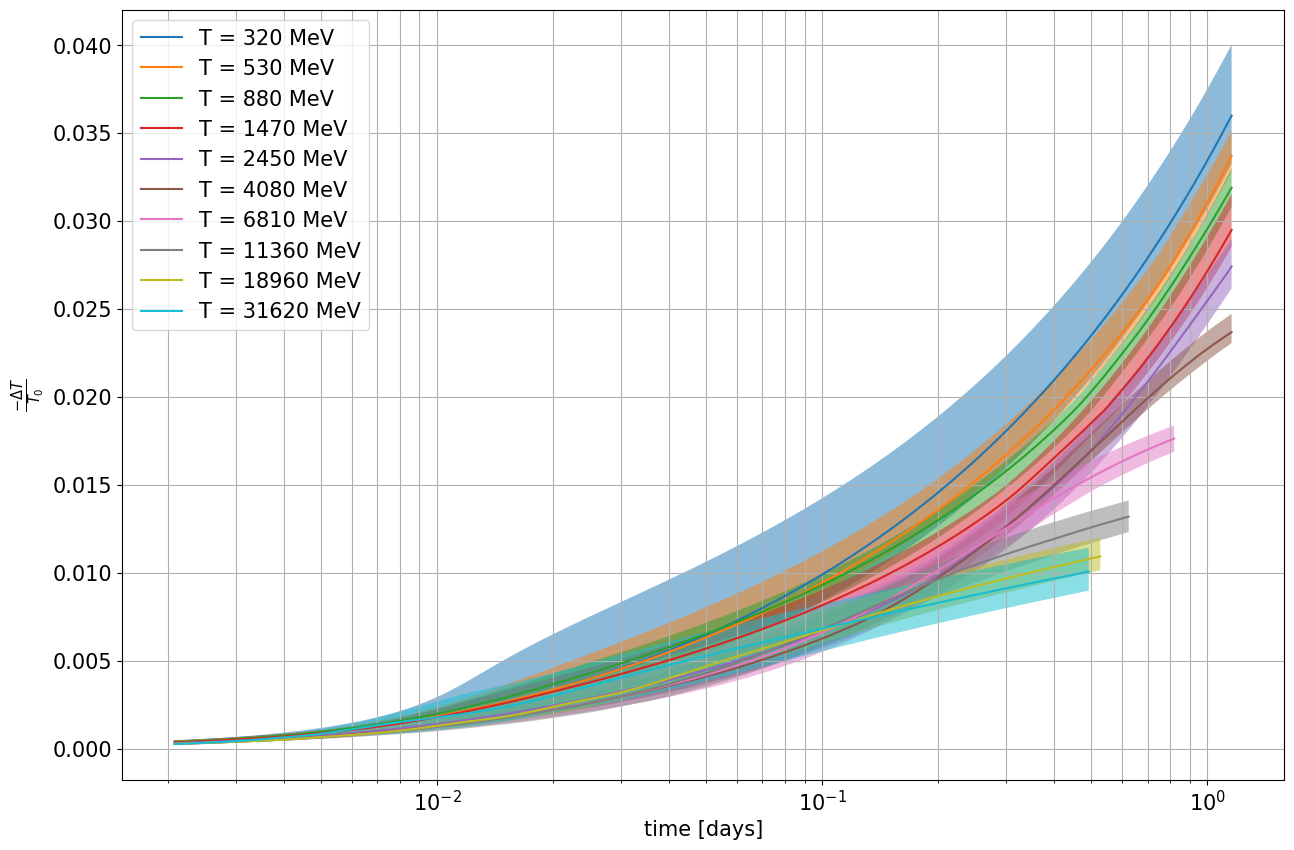

In [34]:

adiabatic_losses = {}
time_energy = {}

for events in tracks:
    for event in events:
        T0 = event["Particle"]["T0"]
        E = event["Track"]["Energy"]
        t = event["Track"]["Clock"]

        if T0 in adiabatic_losses:
            adiabatic_losses[T0].append(E)
        else:
            adiabatic_losses[T0] = [E]
        time_energy[T0] = (np.max(t), len(t)) if T0 not in time_energy else (min(np.max(t), time_energy[T0][0]),
                                                                         min(len(t), time_energy[T0][1]))

plt.figure()

for T in list(adiabatic_losses.keys()):
    max_t, lent = time_energy[T]
    time = np.linspace(0, max_t, lent, endpoint=True)
    En = []
    for arr in adiabatic_losses[T]:
        En.append(arr[:lent])
    En = np.array(En)
    med = np.median(En, axis=0)
    low = np.quantile(En, q=0.15, axis=0)
    high = np.quantile(En, q=0.85, axis=0)
    plt.plot((time/(3600*24))[time/(3600*24)>2e-3],
             (T-med)[time/(3600*24)>2e-3]/T,
             label=f'T = {np.round(T, -1).astype(int)} MeV')
    plt.fill_between((time/(3600*24))[time/(3600*24)>2e-3],
                     y1=(T-low)[time/(3600*24)>2e-3]/T,
                     y2=(T-high)[time/(3600*24)>2e-3]/T,
                     alpha=0.5)

plt.xscale('log')
plt.ylabel(r"$\frac{-\Delta T}{T_0}$")
plt.xlabel('time [days]')
plt.grid(which='both')
plt.legend()
plt.show()